# Game Flow Incorporating Momentum
Takes in the game flow array of probabilities and modifies them according to various explanatory variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools # for shortening double-loop code.
%matplotlib inline
plt.style.use('ggplot')

import tennis_data
import dynamic_model1 as dm1

In [2]:
if False:
    # 2023 Matches
    raw_data = tennis_data.load_2023()

if True:
    # 2021 matches
    raw_data = tennis_data.load_2021()
    
    
if False:
    # 2021 matches of 5 sets
    # TODO
    pass

MATCHES_TO_EXAMINE = raw_data['match_id'].unique()

num = 5

rvalues = np.linspace(1, 1.8, num)
svalues = np.linspace(0, 0.006, num)
qvalues = np.linspace(0.01, 1, num)
uuvalues = np.linspace(1, 1.005, num)
ccvalues = np.linspace(0., 0.001, num)

results = np.zeros( (num, num) )

# CODE TO BE AUTOMATED/TESTED OVER PARAM VALUES.
#if True: 
for i,j in itertools.product( range(num), range(num) ):
    set1_correct = set1_total = set2_correct = set2_total = set3_correct = set3_total = set4_correct = set4_total = 0
    
    # 
    
    print(i,j)
    
    for MATCH_TO_EXAMINE in MATCHES_TO_EXAMINE:
        # TODO: redesign code so that files get loaded *once*, outside the loop.
        model = dm1.MarkovChain(raw_data, MATCH_TO_EXAMINE,  uuv=uuvalues[j]  , ccv=ccvalues[i])
        model.train()
        #if i == 0 and j == 0:
        #     model.graph_momentum()
        result_array = model.prediction()
    
        try:
            set1_correct += result_array[0,0]
            set1_total += 1
    
            set2_correct += result_array[1,0]
            set2_total += 1
    
            set3_correct += result_array[2,0]
            set3_total += 1
    
            set4_correct += result_array[3,0]
            set4_total += 1
        finally:
            continue
    results[i,j] = set4_correct/set4_total # store prediction rate.
    
if False:
    print(rvalues[i], svalues[j])
    print(f"Predicted winner at set 2 correctly {set1_correct} / {set1_total} times")
    print(f"Predicted winner at set 3 correctly {set2_correct} / {set2_total} times")
    print(f"Predicted winner at set 4 correctly {set3_correct} / {set3_total} times")
    print(f"Predicted winner at set 5 correctly {set4_correct} / {set4_total} times")
    
    results[i,j] = set4_correct/set4_total # store prediction rate

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


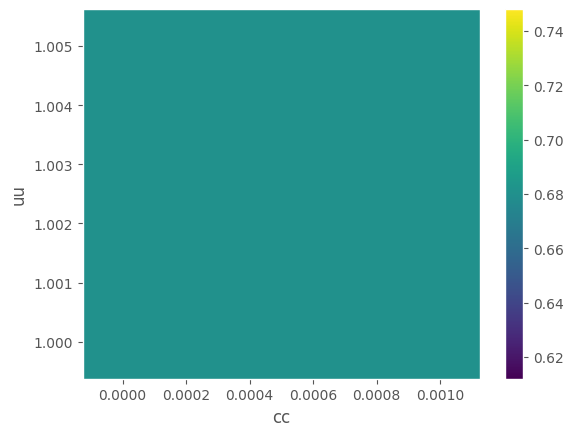

In [3]:
# visualize results of parameter sweep.
fig,ax = plt.subplots()
cax = ax.pcolor(ccvalues, uuvalues, results.T)
ax.set(xlabel='cc', ylabel='uu')
fig.colorbar(cax)

In [4]:
results.T

array([[0.68, 0.68, 0.68, 0.68, 0.68],
       [0.68, 0.68, 0.68, 0.68, 0.68],
       [0.68, 0.68, 0.68, 0.68, 0.68],
       [0.68, 0.68, 0.68, 0.68, 0.68],
       [0.68, 0.68, 0.68, 0.68, 0.68]])

In [5]:
uuvalues

array([1.     , 1.00125, 1.0025 , 1.00375, 1.005  ])

In [6]:
set4_total

25